# Tutorial

This Tutorial shows how to fit a kQEq- Model using different Kernels to a set of reference dipole moments.

In [1]:
import sys
sys.path.append("..")
from ase.io import read
import numpy as np
from kqeq.kqeq import kernel_qeq
from kqeq.funct import get_dipoles
from kqeq.kernel import kernel
import matplotlib.pyplot as plt

We start by loading a training and test set:

In [2]:
# Get data
mols_train = read("../data/QMtrainSimple.xyz@:100",format='extxyz')
mols_test = read("../data/TestQM9.xyz@:100",format='extxyz')

Next we define the Kernel. Let's first use the simple $\delta$-kernel, which evaluates to 1.0 if two atoms have the same atomic number and to 0.0 otherwise. This way all atoms of a given element will have the same electronegativity. In other words: this is just a fancy way to fit a 'normal' QEq model.

In [3]:
Kernel = kernel('Delta','Delta',training_set=mols_train)

In [4]:
# Set up and initialize a kqeq model with the training set and the choosen kernel

my_kqeq = kernel_qeq(Kernel=Kernel,scale_atsize=1.0)

Now we train the model and predict the dipole moments of the validation and training sets. 

Ther are three training functions in the code now. 


`train` function contains currently 2 `targets`; charges and dipoles. Since multiple partial charges models exist, from extended xyz file can be obtaind via `charge_keyword`. For dipole training system dipoles have to be in extended xyz file included as 'dipole_vector' info. Furthermore, diferent weights can be put on different targets via `target_weights`. Both input values should be lists, but if only one target is selected, `targets` can be string and `target_weights` float. (Mixed target is commented in the following cell).

Here we use an arbitrary regularization parameter `lambda_reg`. In principle, the optimal value is system and training set dependent. For comparison, we get the reference values from the atoms objects and plot the results.

First, we will focus on training model with dipoles. We are including examples of others train functions in comments.

In [5]:
# Train a model with a given regularization parameter
my_kqeq.train(targets="dipole", target_weights=1.0,lambda_reg=1.0)
#my_kqeq.train(targets=["dipole","charges"],target_weights=[1.0,0.1],lambda_reg=1.0,charge_keyword="mulliken")


# Predict dipole moments for training and validation set
dipoles_test, charges_test, enegs_test = my_kqeq.predict(mols_test)
dipoles_t, charges_t, enegs_t = my_kqeq.predict(mols_train)

# Get reference values from atoms objects
dipoles_test_ref = get_dipoles(mols_test)
dipoles_t_ref = get_dipoles(mols_train)

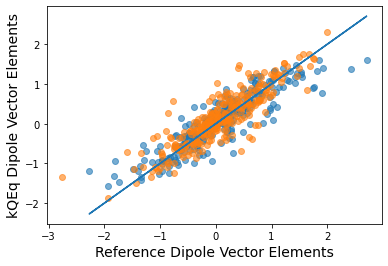

In [6]:
# Plot the results
plt.scatter(dipoles_t_ref,dipoles_t, alpha = 0.6)
plt.scatter(dipoles_test_ref,dipoles_test, alpha = 0.6)
plt.plot(dipoles_t_ref,dipoles_t_ref)
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.show()


Note that there are two ways to run a kQEq model on a new system, namely `.predict` and `.calculate`. The former is for batch applications (e.g. on the full validation set), the latter for predictions on single system (as in the corresponding ase calculator). Dipole moments are always returned in atomic units. You may want to convert them to the more common Debye scale.

In [7]:
# Calculate vs. Predict:
dipoles_v, charges_v, enegs_v = my_kqeq.predict([mols_test[4]])
results                       = my_kqeq.calculate(mols_test[4])
print(dipoles_v)
print(results['dipole_vector'])

[-0.5090227  -0.70629122  0.51149445]
[-0.5090227  -0.70629122  0.51149445]


Now we can use a 'real' Kernel to compare atomic environments. Here, we use the SOAP kernel as implemented in 
```DScribe```. First, we set up a new Kernel object. Note that you can choose different training set here.

In [8]:
### Same for SOAP
desdict = {"nmax" : 6,
           "lmax" : 3,
           "rcut" : 3,
           "sigma": 0.2,
           "periodic": False}

SOAP_Kernel = kernel(Kernel='SOAP',Descriptor='SOAP',descriptor_dict=desdict,training_set=mols_train)


Now we can update the kernel in the `my_kqeq` object. This saves us the hassle of recomputing the blocked inverse Hardness matrix, which can take a while for large datasets.

In [9]:
my_kqeq.update_kernel_matrix(New_Kernel=SOAP_Kernel)

Finally, we can train a model as before and plot the results. You can see that including flexible electronegativities (i.e. which depend on the atomic environments) significantly improves the results. You also see some overfitting in this case (larger deviations for some validation set molecules). This is because we didn't take care to optimize the regularization parameter. Also note that the SOAP based models will improve a lot with more training data.

In [10]:
my_kqeq.train(targets="dipole", target_weights=1.0,lambda_reg=1.0)
#my_kqeq.train(targets=["dipole","charges"],target_weights=[1.0,0.1],lambda_reg=1.0,charge_keyword="mulliken")


# Predict dipole moments for training and validation set
dipoles_test, charges_test, enegs_test = my_kqeq.predict(mols_test)
dipoles_t, charges_t, enegs_t = my_kqeq.predict(mols_train)

# Get reference values from atoms objects
dipoles_test_ref = get_dipoles(mols_test)
dipoles_t_ref = get_dipoles(mols_train)

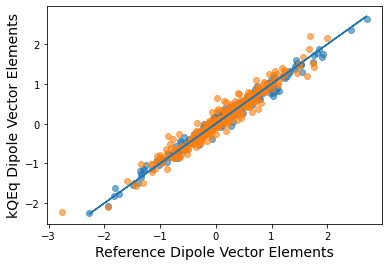

In [11]:
# Plot the results
import matplotlib.pyplot as plt
plt.scatter(dipoles_t_ref,dipoles_t, alpha = 0.6)
plt.scatter(dipoles_test_ref,dipoles_test, alpha = 0.6)
plt.plot(dipoles_t_ref,dipoles_t_ref)
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.show()


In [12]:
# Calculate vs. Predict:
dipoles_v, charges_v, enegs_v = my_kqeq.predict([mols_test[4]])
results                       = my_kqeq.calculate(mols_test[4])
print(dipoles_v)
print(results['dipole_vector'])

[-0.49343004 -0.427125    0.50706384]
[-0.49343004 -0.427125    0.50706384]


All previous examples were done with full training set as representative set in prediction. This can be time consuming and comparing all atoms from training set does not need to be neccesery if  the training set is large enough. 

For this reason, kQeq code has implemented sparse training too. Default methods for picking up representative set is CUR decomposition. Number of atoms in representative set is set up by `sparse_count` variable, which is 1000 by default.

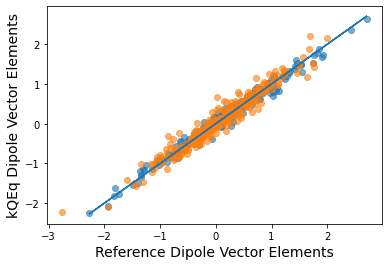

In [13]:
my_kqeq_sparse = kernel_qeq(Kernel=SOAP_Kernel,scale_atsize=1.0,sparse=True, sparse_count = 500)
my_kqeq_sparse.train(targets="dipole",lambda_reg=1.0)

# Predict dipole moments for training and validation set
dipoles_test, charges_test, enegs_test = my_kqeq_sparse.predict(mols_test)
dipoles_t, charges_t, enegs_t = my_kqeq_sparse.predict(mols_train)

# Get reference values from atoms objects
dipoles_test_ref = get_dipoles(mols_test)
dipoles_t_ref = get_dipoles(mols_train)
import matplotlib.pyplot as plt
plt.scatter(dipoles_t_ref,dipoles_t, alpha = 0.6)
plt.scatter(dipoles_test_ref,dipoles_test, alpha = 0.6)
plt.plot(dipoles_t_ref,dipoles_t_ref)
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.show()

Default setting are made to take systems as neutral, however if information about charges of system is passed as a list to the kernel class, it is possible to calculate charges for charged systems

In [14]:
mols_plus = read("../data/PlusSet.xyz@:",format='extxyz')
print(len(mols_plus))
plus_train = mols_plus[:80]
plus_test = mols_plus[80:]
charges_plus_train = [1 for _ in plus_train]
charges_plus_test = [1 for _ in plus_test]

100


In [15]:
SOAP_Kernel_charge = kernel(Kernel='SOAP',
                     Descriptor='SOAP',
                     descriptor_dict=desdict,
                     training_set=plus_train,
                     training_system_charges= charges_plus_train)

In [16]:
my_kqeq_charge = kernel_qeq(Kernel=SOAP_Kernel_charge,scale_atsize=1.0,sparse=True)

In [17]:
my_kqeq_charge.train(targets="dipole", target_weights=1.0,lambda_reg=1.0)

Sum of charges of the testing set: 20.0


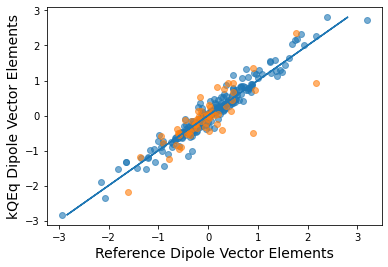

In [18]:
dipoles_train, charges_train, enegs_train = my_kqeq_charge.predict(plus_train,charges_plus_train)
dipoles_plus, charges_plus, enegs_plus = my_kqeq_charge.predict(plus_test,charges_plus_test)
print("Sum of charges of the testing set:", np.sum(charges_plus))
# Get reference values from atoms objects
dipoles_train_ref = get_dipoles(plus_train)
dipoles_plus_ref = get_dipoles(plus_test)

plt.scatter(dipoles_train,dipoles_train_ref, alpha = 0.6)
plt.scatter(dipoles_plus,dipoles_plus_ref, alpha = 0.6)
plt.plot(dipoles_train_ref,dipoles_train_ref)
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.show()